In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms

In [2]:
df = pd.read_csv('AirPassengers.csv')

In [3]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.isna().sum()

Month          0
#Passengers    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
# changing the datatype of Month column to datetime
df['Month'] = pd.to_datetime(df['Month'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [8]:
# setting the Month column as an index
df.set_index('Month', inplace=True)

In [9]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

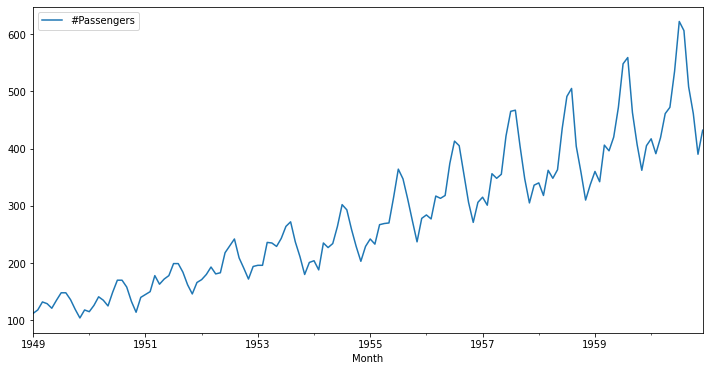

In [10]:
df.plot(figsize=(12,6))

### As we can see on the above plot that our data is not stationary.

### Let's check the stationarity of the data by statistical analysis too. For a data to be stationary, the statistical properties[mean, variance] of the data should not have huge variation over time. Overall behaviour of data should remain constant.

In [11]:
# splitting the data into two halves
data = df.values
split = len(data) / 2
X1, X2 = data[0:int(split)], data[int(split):]

In [12]:
X1.shape, X2.shape

((72, 1), (72, 1))

In [13]:
print('Mean of data X1:', X1.mean())
print('Mean of data X2:', X2.mean())
print("\nVariance of data X1:", X1.var())
print("Variance of data X2:", X2.var())

Mean of data X1: 182.90277777777777
Mean of data X2: 377.69444444444446

Variance of data X1: 2244.0877700617284
Variance of data X2: 7367.962191358024


So on observing the difference between above computed means and variances we can say that our data is not stationary as there is huge variation between mean and variance values over time.

There is some exponential growth in our data from season to season. So let's use log transform to flatten the exponential change.

In [14]:
log_data = np.log(df)

<AxesSubplot:xlabel='Month'>

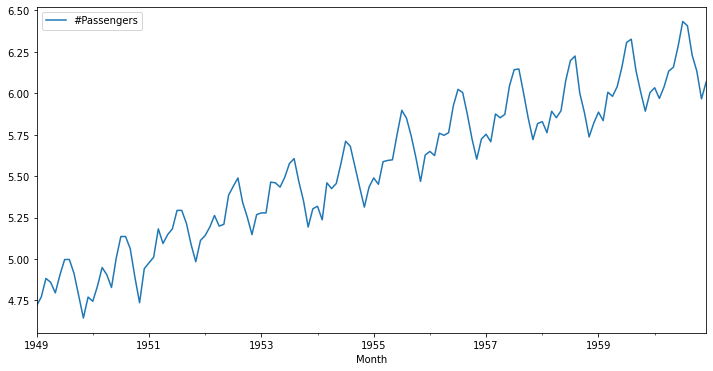

In [15]:
log_data.plot(figsize=(12,6))

In [16]:
# Again splitting the log transformed data into two halves and calculating the mean and variance
data = log_data .values
split = len(data) / 2
X1, X2 = data[0:int(split)], data[int(split):]

print('Mean of data X1:', X1.mean())
print('Mean of data X2:', X2.mean())
print("\nVariance of data X1:", X1.var())
print("Variance of data X2:", X2.var())

Mean of data X1: 5.17514614000377
Mean of data X2: 5.909205777059973

Variance of data X1: 0.06837486074542806
Variance of data X2: 0.04926419375638024


### Though the variation between mean&mean and variance&variance is too small, we can't just say that our data is stationary because the plot is clearly showing some seasonality in our data. 

### So from this observation we can say that this is not always a correct way to check whether the data is stationary or not. Now lets go with some statistical test to check the stationarity of the data.

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adf_test(data_series):
    result = adfuller(data_series)
    print("ADF statistics: {}".format(result[0]))
    print("p-value: {}".format(result[1]))
    if result[1] < 0.05:
        print("\nReject null hypothesis! Indicates that the data is stationary.")
    else:
        print("\nAccept null hypothesis! Indicates that the data is not stationary.")

In [19]:
adf_test(df['#Passengers'])

ADF statistics: 0.8153688792060498
p-value: 0.991880243437641

Accept null hypothesis! Indicates that the data is not stationary.


## ARIMA model cannot handle data with seasonal component so now to make the data stationary we use differencing technique. Seasonal differencing reduces or eliminates the trend and seasonality from data.

In [20]:

df['Passengers First Difference'] = df['#Passengers'] - df['#Passengers'].shift(1)

In [21]:
df.head()

,#Passengers,Passengers First Difference
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [22]:
adf_test(df['Passengers First Difference'].dropna())

ADF statistics: -2.8292668241700047
p-value: 0.05421329028382478

Accept null hypothesis! Indicates that the data is not stationary.


In [23]:
# second differencing
df['Passengers Second Difference'] = df['Passengers First Difference'] - df['Passengers First Difference'].shift(1)

In [24]:
df.head()

,#Passengers,Passengers First Difference,Passengers Second Difference
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [25]:
adf_test(df['Passengers Second Difference'].dropna())

ADF statistics: -16.384231542468513
p-value: 2.7328918500142026e-29

Reject null hypothesis! Indicates that the data is stationary.


In [26]:
# Seasonal(12 months) differencing
df['Passengers 12 Difference'] = df['#Passengers'] - df['#Passengers'].shift(12)

In [27]:
df.head()

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN


In [28]:
adf_test(df['Passengers 12 Difference'].dropna())

ADF statistics: -3.383020726492481
p-value: 0.011551493085514952

Reject null hypothesis! Indicates that the data is stationary.


In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

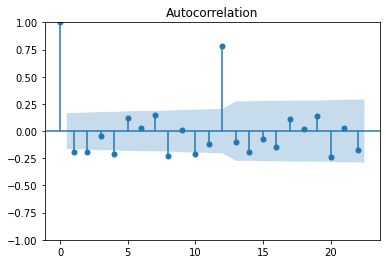

In [30]:
acf = plot_acf(df['Passengers Second Difference'].dropna())

With second differencing, we got q value 12

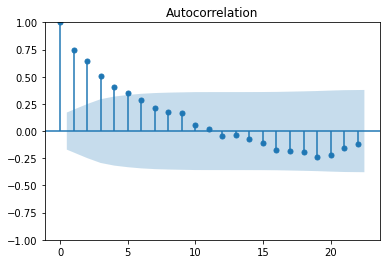

In [31]:
acf12 = plot_acf(df['Passengers 12 Difference'].dropna())

And with 12 differencing ACF plot we got q value 5

/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


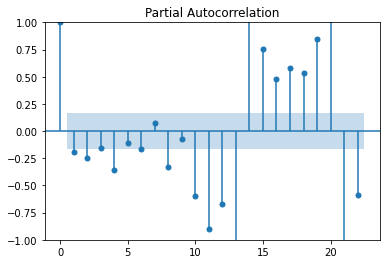

In [32]:
pacf = plot_pacf(df['Passengers Second Difference'].dropna())

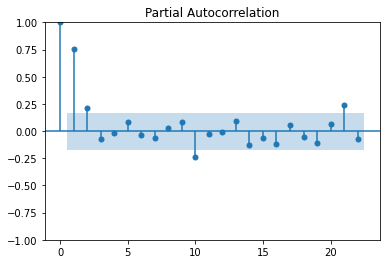

In [33]:
pacf12 = plot_pacf(df['Passengers 12 Difference'].dropna())

On observing the above plot with 12 order differencing, We can take p values either 2 or 10.

In [35]:
df.tail()

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1960-08-01,606,-16.0,-103.0,47.0
1960-09-01,508,-98.0,-82.0,45.0
1960-10-01,461,-47.0,51.0,54.0
1960-11-01,390,-71.0,-24.0,28.0
1960-12-01,432,42.0,113.0,27.0


In [39]:
# Creating train and test data
from datetime import datetime, timedelta
train_dataset_end = datetime(1955, 12, 1)
test_dataset_end = datetime(1960, 12, 1)

In [41]:
train_data =df[:train_dataset_end]
test_data = df[train_dataset_end+timedelta(days=1):test_dataset_end]

In [44]:
train_data.shape, test_data.shape

((84, 4), (60, 4))

In [55]:
df.tail()

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1960-08-01,606,-16.0,-103.0,47.0
1960-09-01,508,-98.0,-82.0,45.0
1960-10-01,461,-47.0,51.0,54.0
1960-11-01,390,-71.0,-24.0,28.0
1960-12-01,432,42.0,113.0,27.0


In [56]:
test_data.index[0], test_data.index[-1]

(Timestamp('1956-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [57]:
#date for which the prediction is to be made
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [59]:
test_data

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1956-01-01,284,6.0,-35.0,42.0
1956-02-01,277,-7.0,-13.0,44.0
1956-03-01,317,40.0,47.0,50.0
1956-04-01,313,-4.0,-44.0,44.0
1956-05-01,318,5.0,9.0,48.0
1956-06-01,374,56.0,51.0,59.0
1956-07-01,413,39.0,-17.0,49.0
1956-08-01,405,-8.0,-47.0,58.0
1956-09-01,355,-50.0,-42.0,43.0


In [64]:
# taking differencing order = 2
arima_model = sms.tsa.ARIMA(train_data['#Passengers'],order=(10, 2, 0))

/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [65]:
model = arima_model.fit()

In [66]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                   84
Model:                ARIMA(10, 2, 0)   Log Likelihood                -357.239
Date:                Sat, 13 Aug 2022   AIC                            736.477
Time:                        16:30:55   BIC                            762.951
Sample:                    01-01-1949   HQIC                           747.106
                         - 12-01-1955                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5166      0.121     -4.262      0.000      -0.754      -0.279
ar.L2         -0.7204      0.121     -5.940      0.000      -0.958      -0.483
ar.L3         -0.4857      0.125     -3.876      0.000      -0.731      -0.240
ar.L4         -0.7505      0.129     -5.819      0.000      -1.003      -0.498
ar.L5         -0.5062      0.169     -2.991      0.003      -0.838      -0.175
ar.L6         -0.5200      0.141     -3.683      0.000      -0.797      -0.243
ar.L7         -0.3051      0.143     -2.127      0.033      -0.586      -0.024
ar.L8         -0.5939      0.155     -3.833      0.000      -0.898      -0.290
ar.L9         -0.2963      0.132     -2.241      0.025      -0.555      -0.037
ar.L10        -0.4825      0.110     -4.376      0.000      -0.699      -0.266
sigma2       336.0939     66.064      5.087      0.000     206.612     465.576
===================================================================================
Ljung-Box (L1) (Q):                  10.86   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               2.85   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
print(pred_start_date)
print(pred_end_date)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [71]:
pred = model.predict(start=pred_start_date, end=pred_end_date)

In [72]:
# Calulating the difference between predicted value and the actual value and storing the computed differece in variable `residual`
residuals = test_data['#Passengers'] - pred

In [73]:
residuals

Month
1956-01-01    -16.183612
1956-02-01    -32.478355
1956-03-01      0.556985
1956-04-01      5.172456
1956-05-01     -0.544234
1956-06-01     25.077917
1956-07-01     46.979713
1956-08-01     58.432466
1956-09-01     22.879031
1956-10-01     -1.734755
1956-11-01    -40.623912
1956-12-01    -33.828197
1957-01-01    -34.840405
1957-02-01    -55.098234
1957-03-01      5.312171
1957-04-01     -2.080465
1957-05-01     -6.157694
1957-06-01     40.783483
1957-07-01     82.680626
1957-08-01     94.147419
1957-09-01     39.889902
1957-10-01     -9.108926
1957-11-01    -66.293791
1957-12-01    -49.323597
1958-01-01    -52.077839
1958-02-01    -73.405852
1958-03-01    -26.404583
1958-04-01    -43.572859
1958-05-01    -39.448082
1958-06-01     21.744314
1958-07-01     80.146583
1958-08-01     97.329454
1958-09-01      1.513662
1958-10-01    -47.089150
1958-11-01   -108.125316
1958-12-01    -89.012377
1959-01-01    -69.205584
1959-02-01    -85.352235
1959-03-01    -22.150992
1959-04-01    -36.7

<AxesSubplot:ylabel='Density'>

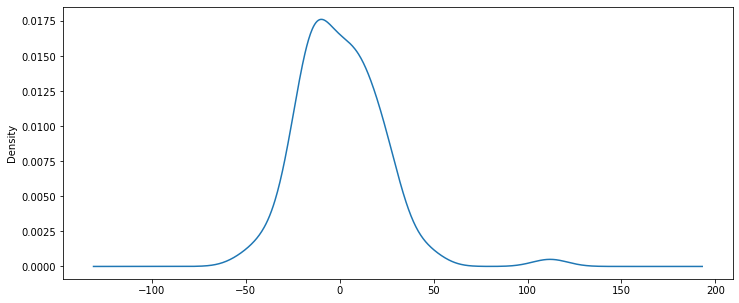

In [77]:
model.resid.plot(kind='kde', figsize=(12,5))

In [78]:
# Creating a new column of predicted values
test_data['predicted_value'] = pred

/tmp/ipykernel_3795/2400886956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_value'] = pred


<AxesSubplot:xlabel='Month'>

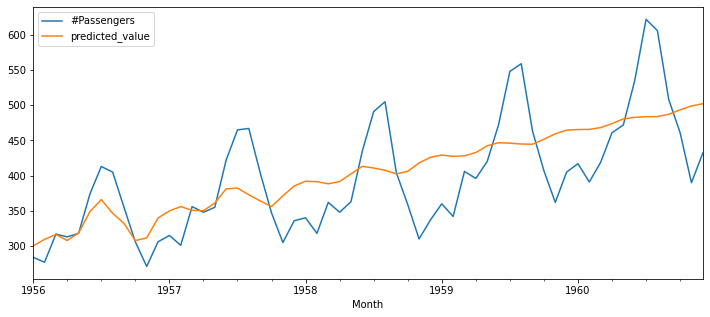

In [79]:
test_data[['#Passengers', 'predicted_value']].plot(figsize=(12,5))

As our data is seasonal data, ARIMA performed poorly, so let's fit the dtaa with SARIMA model

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


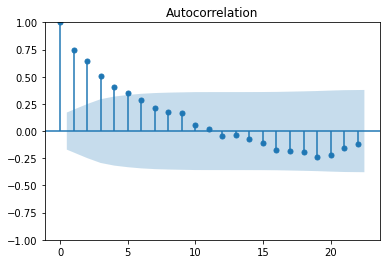

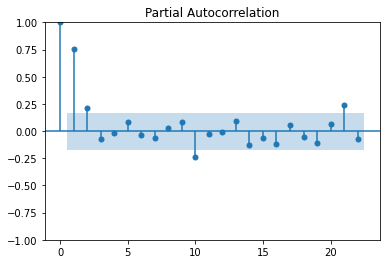

In [100]:
acf12 = plot_acf(df["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df["Passengers 12 Difference"].dropna())

Observing autocorrelation plot, we can take q value = 5 and from partial autocorreltaiton plot, we can take p value = 2

In [101]:
sarimax_model = SARIMAX(train_data['#Passengers'], order=(2, 0, 5), seasonal_order=(0,1,0,12))

/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/sushmita/anaconda3/envs/tfEnv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [102]:
sarimax_fitted_model = sarimax_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18183D+00    |proj g|=  3.68354D-02

At iterate    5    f=  3.17618D+00    |proj g|=  1.91560D-02

At iterate   10    f=  3.17380D+00    |proj g|=  3.11290D-03

At iterate   15    f=  3.17305D+00    |proj g|=  1.42250D-03

At iterate   20    f=  3.17300D+00    |proj g|=  2.86141D-03

At iterate   25    f=  3.17222D+00    |proj g|=  1.11570D-02

At iterate   30    f=  3.17065D+00    |proj g|=  9.79228D-03

At iterate   35    f=  3.17045D+00    |proj g|=  2.40416D-04

At iterate   40    f=  3.17045D+00    |proj g|=  2.17044D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [103]:
sarimax_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                   84
Model:             SARIMAX(2, 0, 5)x(0, 1, [], 12)   Log Likelihood                -266.318
Date:                             Sat, 13 Aug 2022   AIC                            548.636
Time:                                     17:13:25   BIC                            566.850
Sample:                                 01-01-1949   HQIC                           555.887
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3148      1.447      0.909      0.363      -1.521       4.150
ar.L2         -0.3310      1.423     -0.233      0.816      -3.121       2.459
ma.L1         -0.5814      1.436     -0.405      0.685      -3.395       2.232
ma.L2          0.1519      0.425      0.358      0.721      -0.681       0.985
ma.L3         -0.2934      0.221     -1.325      0.185      -0.727       0.141
ma.L4          0.1246      0.411      0.303      0.762      -0.681       0.930
ma.L5          0.0729      0.174      0.419      0.675      -0.268       0.413
sigma2        92.1028     17.259      5.337      0.000      58.276     125.930
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.52
Prob(Q):                              0.87   Prob(JB):                         0.28
Heteroskedasticity (H):               2.13   Skew:                             0.45
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
#date for which the prediction is to be made
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [108]:
sarima_predicted = sarimax_fitted_model.predict(start=pred_start_date, end=pred_end_date)

In [109]:
# Again calculating residuals
sarimax_residuals = test_data['#Passengers'] - sarima_predicted

<AxesSubplot:ylabel='Density'>

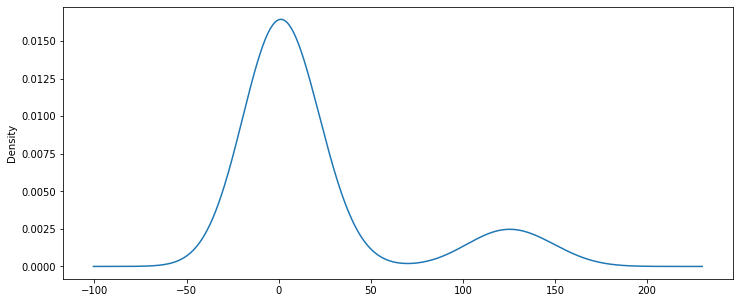

In [113]:
sarimax_fitted_model.resid.plot(kind='kde', figsize=(12,5))

In [114]:
test_data['sarima_predicted'] = sarima_predicted

/tmp/ipykernel_3795/2805857347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sarima_predicted'] = sarima_predicted


In [115]:
test_data.head()

,#Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference,predicted_value,sarima_predicted
Month,,,,,,
1956-01-01,284,6.0,-35.0,42.0,300.183612,287.156049
1956-02-01,277,-7.0,-13.0,44.0,309.478355,281.418152
1956-03-01,317,40.0,47.0,50.0,316.443015,310.582627
1956-04-01,313,-4.0,-44.0,44.0,307.827544,310.746078
1956-05-01,318,5.0,9.0,48.0,318.544234,311.287558


<AxesSubplot:xlabel='Month'>

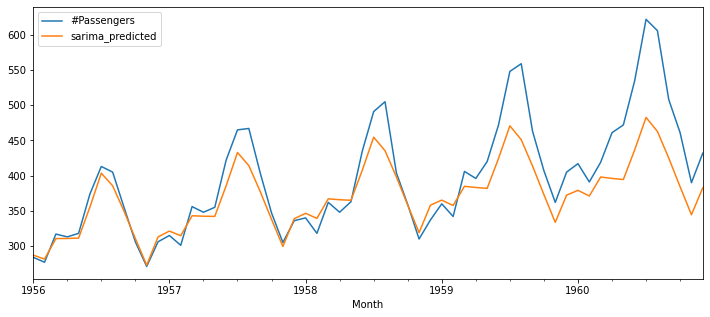

In [116]:
test_data[['#Passengers', 'sarima_predicted']].plot(figsize=(12,5))

<AxesSubplot:xlabel='Month'>

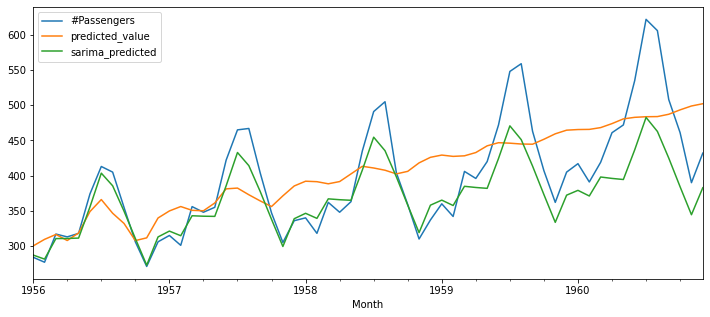

In [118]:
test_data[['#Passengers', 'predicted_value', 'sarima_predicted']].plot(figsize=(12,5))

### After conducting the above experimentation, we clearly see that ARIMA model does not perform well with seasonal data, but SARIMAX does.